In [75]:
import openai
from typing import List, Dict, Generator, Optional

import tiktoken
import pandas as pd
from dotenv import load_dotenv
import sys

import re
import random
import time
import praw
import os

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [76]:
model = "gpt-3.5-turbo"
load_dotenv(".env")

from dotenv import dotenv_values
config = dotenv_values(".env")
openai.api_key = config["OPENAI_API_KEY"]

reddit = praw.Reddit(
    client_id=os.environ["REDDIT_CLIENT_ID"],
    client_secret=os.environ["REDDIT_CLIENT_SECRET"],
    user_agent=f"script:test:0.0.1 (by u/yourusername)",
)

In [77]:
def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613"):
    """Return the number of tokens used by a list of messages."""
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")
    if model in {
        "gpt-3.5-turbo-0613",
        "gpt-3.5-turbo-16k-0613",
        "gpt-4-0314",
        "gpt-4-32k-0314",
        "gpt-4-0613",
        "gpt-4-32k-0613",
    }:
        tokens_per_message = 3
        tokens_per_name = 1
    elif model == "gpt-3.5-turbo-0301":
        tokens_per_message = (
            4  # every message follows <|start|>{role/name}\n{content}<|end|>\n
        )
        tokens_per_name = -1  # if there's a name, the role is omitted
    elif "gpt-3.5-turbo" in model:
        return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0613")
    elif "gpt-4" in model:
        print(
            "Warning: gpt-4 may update over time. Returning num tokens assuming gpt-4-0613."
        )
        return num_tokens_from_messages(messages, model="gpt-4-0613")
    else:
        raise NotImplementedError(
            f"""num_tokens_from_messages() is not implemented for model {model}. See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens."""
        )
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
    return num_tokens

# Getting Reddit Comments


In [78]:
DF_COLUMNS = ["subreddit", "submission_id", "score", "comment_body"]
filename, subreddits = (
    "epl_top_8.csv",
    [
        "reddevils",
        "LiverpoolFC",
        "chelseafc",
        "Gunners",
        "coys",
        "MCFC",
        "Everton",
        "NUFC",
    ],
)

In [79]:
# Utility functions for fetching comments from submissions
def comment_generator(submission) -> Generator:
    # Do not bother expanding MoreComments (follow-links)
    for comment in submission.comments.list():
        if (
            hasattr(comment, "body")
            and comment.body != "[deleted]"
            and comment.body != "[removed]"
        ):
            yield (comment)

In [80]:
def collect_comments(
    filename: str,
    target_comments_per_subreddit: int,
    max_comments_per_submission: int,
    max_comment_length: int,
    reddit: praw.Reddit,
) -> pd.DataFrame:
    """
    Collect comments from the top submissions in each subreddit.

    Cache results at cache_filename.

    Return a dataframe with columns: subreddit, submission_id, score, comment_body
    """
    try:
        df = pd.read_csv(filename, index_col="id")
        assert df.columns.tolist() == DF_COLUMNS
    except FileNotFoundError:
        df = pd.DataFrame(columns=DF_COLUMNS)

    # dict like {comment_id -> {column -> value}}
    records = df.to_dict(orient="index")

    for subreddit_index, subreddit_name in enumerate(subreddits):
        print(f"Processing Subreddit: {subreddit_name}")

        processed_comments_for_subreddit = len(df[df["subreddit"] == subreddit_name])

        if processed_comments_for_subreddit >= target_comments_per_subreddit:
            print(
                f"Enough comments fetched for {subreddit_name}, continuing to next subreddit."
            )
            continue

        # `top`` is a generator, grab submissions until we break (within this loop).
        for submission in reddit.subreddit(subreddit_name).top(time_filter="month"):
            if processed_comments_for_subreddit >= target_comments_per_subreddit:
                break

            # The number of comments that we already have for this subreddit
            processed_comments_for_submission = len(
                df[df["submission_id"] == submission.id]
            )

            for comment in comment_generator(submission):
                if (
                    processed_comments_for_submission >= max_comments_per_submission
                    or processed_comments_for_subreddit >= target_comments_per_subreddit
                ):
                    break

                if comment.id in records:
                    print(
                        f"Skipping comment {subreddit_name}-{submission.id}-{comment.id} because we already have it"
                    )
                    continue

                body = comment.body[:max_comment_length].strip()
                records[comment.id] = {
                    "subreddit": subreddit_name,
                    "submission_id": submission.id,
                    "comment_body": body,
                }

                processed_comments_for_subreddit += 1
                processed_comments_for_submission += 1

            # Once per post write to disk.
            print(f"CSV rewritten with {len(records)} rows.\n")
            df = pd.DataFrame.from_dict(records, orient="index", columns=DF_COLUMNS)
            df.to_csv(filename, index_label="id")

    print("Completed.")
    return df

# Sentiment Analysis on Comments


In [81]:
MAX_ATTEMPTS = 3


def generate_prompt_messages(s: str) -> List[Dict]:
    return [
        {
            "role": "user",
            "content": """
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

The traffic is quite annoying.
""".strip(),
        },
        {"role": "assistant", "content": "-0.75"},
        {
            "role": "user",
            "content": """
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

The library is downtown.
""".strip(),
        },
        {"role": "assistant", "content": "0.0"},
        {
            "role": "user",
            "content": """
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

Even though it's humid, I really love the summertime. Everything is so green and the sun is out all the time.
""".strip(),
        },
        {"role": "assistant", "content": "0.8"},
        {
            "role": "user",
            "content": f"""
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

{s}
""".strip(),
        },
    ]

In [82]:
class UnscorableCommentError(Exception):
    pass


from tenacity import (
    retry,
    wait_random_exponential,
    retry_if_exception_type,
    stop_after_attempt,
)


@retry(
    wait=wait_random_exponential(multiplier=1, max=30),
    stop=stop_after_attempt(3),
    retry=retry_if_exception_type(UnscorableCommentError)
    | retry_if_exception_type(openai.APIConnectionError)
    | retry_if_exception_type(openai.APIError)
    | retry_if_exception_type(openai.RateLimitError),
    reraise=True,  # Reraise the last exception
)
def score_sentiment(s: str, model: str) -> float:
    messages = generate_prompt_messages(s)
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
    )
    score_response = response.choices[0].message.content.strip()
    # This will raise an Attribute Error if the regular expression doesn't match
    try:
        return float(re.search(r"([-+]?\d*\.?\d+)", score_response).group(1))
    except AttributeError:
        raise UnscorableCommentError(f"Could not score comment: {s}")

In [83]:
def estimate_cost_to_score_comments(df, model) -> float:
    """Estimate the number of tokens in a dataframe's comment_body column"""
    num_tokens = 0
    for comment in df["comment_body"]:
        num_tokens += num_tokens_from_messages(generate_prompt_messages(comment), model)
    return num_tokens * (0.002 / 1000)

In [84]:
def score_sentiments(filename: str, model: str) -> pd.DataFrame:
    """
    Score sentiments contained in comments in filename.
    """
    df = pd.read_csv(filename, index_col="id")
    assert df.columns.tolist() == DF_COLUMNS

    print(
        f"Scoring {len(df)} comments will cost approximately ${estimate_cost_to_score_comments(df, model):.2f}."
    )
    records = df.to_dict(orient="index")

    for index, item in enumerate(records.items()):
        comment_id, comment = item

        if not pd.isna(comment["score"]):
            print(f"{comment_id} was already scored. Skipping.")
            continue

        body = comment["comment_body"]
        try:
            score = score_sentiment(body, model=model)
        except UnscorableCommentError:
            # The score_sentiment method will retry 3 times before letting this error pass through.
            # If it does, we will consider this comment un-processable and skip it.
            # For other errors, such as APIConnectionError, we will fail completely and let the user know.
            continue
        print(
            f"""
            {comment_id} - ({index + 1} of {len(records)} Comments)
            Body: {body[:80]}
            Score: {score}""".strip()
        )

        records[comment_id]["score"] = score
        df = pd.DataFrame.from_dict(records, orient="index", columns=DF_COLUMNS)
        df.to_csv(filename, index_label="id")

    print("Scoring completed.")
    return df

# Plotting Sentiment

In [85]:
def get_avg_scores_sorted(df):
    avg_scores = df.groupby("subreddit")["score"].mean().reset_index()
    avg_scores = avg_scores.sort_values("score", ascending=True)
    return avg_scores

In [86]:
# Define our plotting function


# https://seaborn.pydata.org/examples/kde_ridgeplot.html
def get_avg_score_by_subreddit(dataframe):
    """
    Given a pandas DataFrame with columns "subreddit" and "score", returns a new DataFrame
    with the average score and standard deviation for each subreddit.
    """
    # Group by subreddit and calculate the mean and standard deviation for each group
    subreddit_stats = dataframe.groupby("subreddit")["score"].agg(["mean", "std"])

    # Rename columns to indicate that they represent the mean and standard deviation
    subreddit_stats.columns = ["mean_score", "standard_deviation"]

    subreddit_stats = subreddit_stats.sort_values("mean_score", ascending=True)

    # Return the new DataFrame
    return subreddit_stats


def plot_sentiments(df):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Create the data
    df_scores = df[["score", "subreddit"]]

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-0.25, light=0.7)
    g = sns.FacetGrid(
        df_scores,
        row="subreddit",
        row_order=get_avg_score_by_subreddit(df_scores).index.to_list(),
        hue="subreddit",
        aspect=15,
        height=0.5,
        palette=pal,
    )

    # Draw the densities in a few steps
    g.map(
        sns.kdeplot,
        "score",
        bw_adjust=0.5,
        clip_on=False,
        fill=True,
        alpha=1,
        linewidth=1.5,
    )
    g.map(sns.kdeplot, "score", clip_on=False, color="w", lw=2, bw_adjust=0.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(
            0,
            0.2,
            label,
            fontweight="bold",
            color=color,
            ha="left",
            va="center",
            transform=ax.transAxes,
        )

    g.map(label, "score")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-0.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # display(g.fig)

# Run everything

In [87]:
NUM_SUBREDDITS = len(subreddits)
TARGET_COMMENTS_PER_SUBREDDIT = 50
MAX_COMMENTS_PER_SUBMISSION = 10
MAX_COMMENT_LENGTH = 2000

collect_comments(
    filename=filename,
    target_comments_per_subreddit=TARGET_COMMENTS_PER_SUBREDDIT,
    max_comments_per_submission=MAX_COMMENTS_PER_SUBMISSION,
    max_comment_length=MAX_COMMENT_LENGTH,
    reddit=reddit,
)

Processing Subreddit: reddevils
Enough comments fetched for reddevils, continuing to next subreddit.
Processing Subreddit: LiverpoolFC
Enough comments fetched for LiverpoolFC, continuing to next subreddit.
Processing Subreddit: chelseafc
Enough comments fetched for chelseafc, continuing to next subreddit.
Processing Subreddit: Gunners
Enough comments fetched for Gunners, continuing to next subreddit.
Processing Subreddit: coys
Enough comments fetched for coys, continuing to next subreddit.
Processing Subreddit: MCFC
Enough comments fetched for MCFC, continuing to next subreddit.
Processing Subreddit: Everton
Enough comments fetched for Everton, continuing to next subreddit.
Processing Subreddit: NUFC
Enough comments fetched for NUFC, continuing to next subreddit.
Completed.


,subreddit,submission_id,score,comment_body
id,,,,
lhfdsx3,reddevils,1eorqh2,NaN,BOOOOM\n\nhttps://preview.redd.it/gjw1fcd7ythd...
lhfdf8w,reddevils,1eorqh2,NaN,ITS GONNA BE A GOOD DAY
lhfelc1,reddevils,1eorqh2,NaN,https://preview.redd.it/f5b6q5d6zthd1.jpeg?wid...
lhfdndv,reddevils,1eorqh2,NaN,That's a really good price for both. Glad we d...
lhfeijo,reddevils,1eorqh2,NaN,Forgot one\n\n\nDe ligt ✅
...,...,...,...,...
lgbqliz,NUFC,1ej8ibh,NaN,"Bruno: I suite this captains band, don't you t..."
lgcjtg0,NUFC,1ej8ibh,NaN,Before his impressive stint of not getting boo...
lgc5brb,NUFC,1ej8ibh,NaN,Bruno Guimaraes is my favourite Newcastle Unit...


In [88]:
df = score_sentiments(
    filename=filename,
    model=model,
)

Scoring 400 comments will cost approximately $0.19.
lhfdsx3 - (1 of 400 Comments)
            Body: BOOOOM

https://preview.redd.it/gjw1fcd7ythd1.png?width=1978&format=png&auto=web
            Score: 0.0
lhfdf8w - (2 of 400 Comments)
            Body: ITS GONNA BE A GOOD DAY
            Score: 1.0
lhfelc1 - (3 of 400 Comments)
            Body: https://preview.redd.it/f5b6q5d6zthd1.jpeg?width=950&format=pjpg&auto=webp&s=75b
            Score: 0.0
lhfdndv - (4 of 400 Comments)
            Body: That's a really good price for both. Glad we didn't bow down to Bayern.
            Score: 0.8
lhfeijo - (5 of 400 Comments)
            Body: Forgot one


De ligt ✅
            Score: 0.5
lhfdgb5 - (6 of 400 Comments)
            Body: RE-UNITED

https://preview.redd.it/z3kkx5fjxthd1.jpeg?width=923&format=pjpg&auto
            Score: 0.5
lhfdoaq - (7 of 400 Comments)
            Body: This might be my first Orny bomba, pure fluke I checked the bird site and he'd p
            Score: -0.2
lhfdrw1

li8xb4o - (62 of 400 Comments)
            Body: Should say Richard Hughes came in and bought a pizza for 2026.
            Score: 0.2
li8x5x2 - (63 of 400 Comments)
            Body: Should probably say Richard Hughes
            Score: -0.25
li93rnp - (64 of 400 Comments)
            Body: Just imagine the quality of Pizza we will buy next year though lads
            Score: 0.7
li904gr - (65 of 400 Comments)
            Body: I dont think Arne is the problem
            Score: 0.4
li8xa7m - (66 of 400 Comments)
            Body: Hughes ordered the Mighty Meaty, and was told they didn’t have bacon but did hav
            Score: -0.5
li933ym - (67 of 400 Comments)
            Body: He said that there was only one topping that he could eat, all the others were i
            Score: -0.5
li985fu - (68 of 400 Comments)
            Body: Silence, brand.
            Score: 0.0
li9mjjk - (69 of 400 Comments)
            Body: He came in and sold them more pizza
            Score: 0.5
li98ddo

leusj4k - (124 of 400 Comments)
            Body: Oh this is going to be spicy in the new Welcome to Wrexham season
            Score: 0.5
leusxdh - (125 of 400 Comments)
            Body: Shouldn't have messed with Levi in his own stadium.
            Score: 0.5
leust6v - (126 of 400 Comments)
            Body: lol Colwill handled that guy though at least
            Score: 0.5
leupux6 - (127 of 400 Comments)
            Body: Go on Levi!
            Score: 0.5
leuuzjh - (128 of 400 Comments)
            Body: Levi is strong mother fucker 😂
            Score: 0.5
leun1kb - (129 of 400 Comments)
            Body: What the fuck were both of them doing
            Score: -0.5
leuvinb - (130 of 400 Comments)
            Body: Levi man handled him lol
            Score: 0.5
lgvdaa0 - (131 of 400 Comments)
            Body: As part of our sub rules, we ask that all meme posts be posted on Meme Tuesday. 
            Score: 0.2
lgvicy1 - (132 of 400 Comments)
            Body: 2021 felt like 

le46ies - (189 of 400 Comments)
            Body: Impressive looking couple. How many marriages have occurred since Arteta has bee
            Score: 0.2
le3ugx3 - (190 of 400 Comments)
            Body: All part of Arteta’s plan. Can’t join in on the wife sharing if you don’t have a
            Score: -0.5
likxkjo - (191 of 400 Comments)
            Body: Damn the speed on this is amazing. What you got under the hood man
            Score: 0.6
likxpu8 - (192 of 400 Comments)
            Body: Groped Jesus too.

Disgraceful that he didn't get even a yellow but what can I e
            Score: -0.9
likxrbt - (193 of 400 Comments)
            Body: Dipshit commentator said “he stopped before his emotions got the better of him”

            Score: -0.75
likxwaq - (194 of 400 Comments)
            Body: Havertz eyes in this comic are killing me rofl.
            Score: 0.5
likxtl5 - (195 of 400 Comments)
            Body: Infuriating that this guy did not even get a yellow today.
          

lh8ylzj - (250 of 400 Comments)
            Body: Truly an icon
            Score: 0.9
liqvhlm - (251 of 400 Comments)
            Body: Mateo Kovacic vs Chelsea:  
  
1 Goal  
84 Touches  
62 Accurate Passes  
97% Pa
            Score: 0.9
liqwfsr - (252 of 400 Comments)
            Body: https://preview.redd.it/9b2cqqoalgjd1.jpeg?width=1290&format=pjpg&auto=webp&s=2f
            Score: 0.0
liqzrhw - (253 of 400 Comments)
            Body: One you accept what Kova is, you realize he's an excellent player.
            Score: 0.6
liqywa0 - (254 of 400 Comments)
            Body: He absolutely walked pass 200 milly. King
            Score: 0.2
lir1us5 - (255 of 400 Comments)
            Body: can finally say we have a rodri backup in kovacic?
            Score: 0.5
liqwoo8 - (256 of 400 Comments)
            Body: Always found it odd they didn’t want to keep him, he’d be their best player at t
            Score: -0.5
lir05w9 - (257 of 400 Comments)
            Body: Kovacic was eventuall

likz66r - (314 of 400 Comments)
            Body: We lost to the pigeons
            Score: -0.5
lil5z12 - (315 of 400 Comments)
            Body: And Onana just scored for Villa
            Score: 0.6
liky022 - (316 of 400 Comments)
            Body: The mind fairly boggles
            Score: 0.2
lil4guh - (317 of 400 Comments)
            Body: Typical Everton matchday then...
            Score: -0.5
lil9t0b - (318 of 400 Comments)
            Body: Keane trying to play out from the back and chasing the ball like a dog and expos
            Score: -0.9
lil1tf4 - (319 of 400 Comments)
            Body: The VAR decisions are becoming increasingly controversial. That red card was a t
            Score: -0.5
lilddxk - (320 of 400 Comments)
            Body: I'm so happy we lost the first game... We usually come out the gate winning 5 an
            Score: -0.5
lfo7djg - (321 of 400 Comments)
            Body: Up the Big Bois ™️ Toffees
            Score: 0.5
lfo9jqu - (322 of 400 Comment

lfy5jlo - (379 of 400 Comments)
            Body: Lol is that Disney Tokyo?

Edit: you lot mad I asked if it was Disneyland?
            Score: -0.2
lfy6wtg - (380 of 400 Comments)
            Body: Some talent in this photo 😮‍💨
            Score: 0.5
lfmfkvn - (381 of 400 Comments)
            Body: Welcome to [r/NUFC!](https://reddit.com/r/nufc)

[Join our Discord Server](https
            Score: 1.0
lfmh9m2 - (382 of 400 Comments)
            Body: No, I think you got it wrong. That's the famous, **Geordie Groove.** Nineties po
            Score: 0.6
lfmh79m - (383 of 400 Comments)
            Body: Two Brazilians and an Italian walk into st James’…
            Score: 0.1
lfmhz89 - (384 of 400 Comments)
            Body: Tonali looks like he's going to star in a music video where he walks down the st
            Score: -0.5
lfmnwvv - (385 of 400 Comments)
            Body: Please all stay fit please all stay fit please all stay fit please all stay fit 
            Score: 0.5
lfmmwc7

C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommo

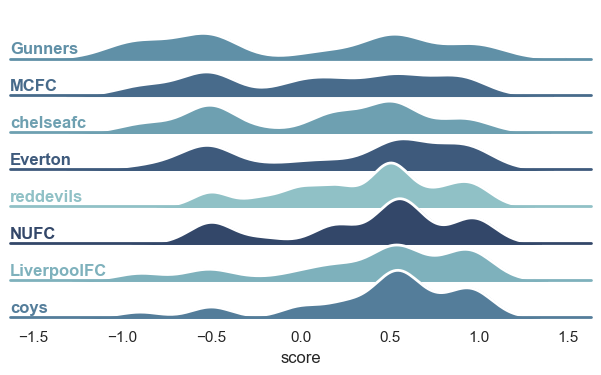

In [89]:
plot_sentiments(df)